In [1]:
from torchvision.datasets import ImageFolder
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import random_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
!gdown 1IzU7-mLuVU0kdsSq1Xf0UmdHQDH5_IUq

Downloading...
From: https://drive.google.com/uc?id=1IzU7-mLuVU0kdsSq1Xf0UmdHQDH5_IUq
To: /content/Spec.rar
100% 171M/171M [00:01<00:00, 104MB/s]


In [ ]:
!unrar x Spec.rar

In [5]:
!rm /content/Spec/neutral/75-98-01-50-86-22-46.png

In [6]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

In [7]:
dataset = ImageFolder('/content/Spec',transform=data_transform)

#The Frequency of each class in the dataset

In [8]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
class_counts = {class_idx: 0 for class_idx in range(len(dataset.classes))}

for _, label in dataloader:
    class_counts[label[0].item()] += 1

for class_idx, count in class_counts.items():
    class_name = dataset.classes[class_idx]
    print(f"{class_name}: {count} instances")

angry: 935 instances
disgust: 652 instances
fear: 652 instances
happy: 932 instances
neutral: 876 instances
sad: 852 instances


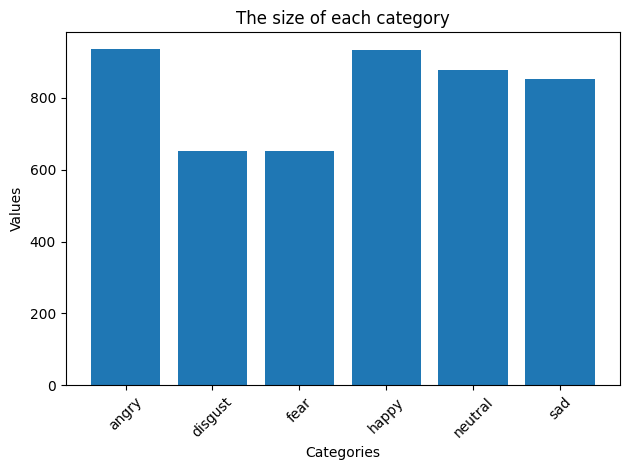

In [19]:
categories = dataset.classes
values = list(class_counts.values())

plt.bar(categories, values)

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('The size of each category')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

In [11]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [12]:
classes = dataset.classes
num_emotions = len(classes)

# Loading the Resnet50 as the detection model for SER

In [32]:
model = models.resnet50(weights=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_emotions)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

###Freezing each layer except the last one

In [34]:
for name, param in model.named_parameters():
    if param.requires_grad and 'fc' not in name:
        param.requires_grad = False

In [35]:
def plot_accuracy(train_accuracy,label=""):
    epochs = np.arange(1, len(train_accuracy) + 1)

    plt.plot(epochs, train_accuracy, 'b', label=f'{label} Accuracy')
    plt.title(f'{label} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Training the model and printing accuracy and F1-score

In [36]:
def train_model():
  F1_Test = []
  loss_train = []

  num_epochs = 20
  start_time = time.time()
  for epoch in range(num_epochs):
      """ Training Phase """
      model.train()
      running_loss = 0.
      with tqdm(train_loader,unit="batch") as tepoch:
          tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
          for inputs, labels in tepoch:
              inputs = inputs.to(device)
              labels = labels.to(device)

              optimizer.zero_grad()
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              loss.backward()
              optimizer.step()
              running_loss += loss.item() * inputs.size(0)
              tepoch.set_postfix(loss=loss.item())
      epoch_loss = loss.item()
      loss_train.append(epoch_loss)


      with torch.no_grad():
          running_corrects = 0
          predictions = []
          true_labels = []
          for inputs, labels in test_loader:
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              running_corrects += torch.sum(preds == labels.data)
              predictions.extend(preds.tolist())
              true_labels.extend(labels.tolist())

          epoch_acc = running_corrects / len(test_set) * 100.
          f1 = f1_score(true_labels, predictions, average='macro') * 100
          F1_Test.append(f1)
          print('[Valid #{}] Loss: {:.4f} Acc: {:.4f} F1: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, f1, time.time()- start_time))
  return F1_Test ,loss_train


In [37]:
F1_Test, loss_train = train_model()

Epoch 1/20: 100%|██████████| 123/123 [00:45<00:00,  2.71batch/s, loss=1.28]


[Valid #0] Loss: 1.2754 Acc: 72.2449 F1: 72.4236% Time: 56.8854s


Epoch 2/20: 100%|██████████| 123/123 [00:46<00:00,  2.62batch/s, loss=1.03]


[Valid #1] Loss: 1.0314 Acc: 72.0408 F1: 72.5381% Time: 114.3104s


Epoch 3/20: 100%|██████████| 123/123 [00:45<00:00,  2.69batch/s, loss=0.923]


[Valid #2] Loss: 0.9235 Acc: 74.2857 F1: 74.2804% Time: 171.3542s


Epoch 4/20: 100%|██████████| 123/123 [00:44<00:00,  2.76batch/s, loss=0.725]


[Valid #3] Loss: 0.7245 Acc: 76.9388 F1: 77.3139% Time: 227.4039s


Epoch 5/20: 100%|██████████| 123/123 [00:45<00:00,  2.67batch/s, loss=0.791]


[Valid #4] Loss: 0.7907 Acc: 75.3061 F1: 76.3027% Time: 283.3776s


Epoch 6/20: 100%|██████████| 123/123 [00:45<00:00,  2.70batch/s, loss=1.02]


[Valid #5] Loss: 1.0206 Acc: 78.3673 F1: 78.3457% Time: 340.3704s


Epoch 7/20: 100%|██████████| 123/123 [00:44<00:00,  2.78batch/s, loss=0.905]


[Valid #6] Loss: 0.9050 Acc: 76.7347 F1: 77.3780% Time: 395.9020s


Epoch 8/20: 100%|██████████| 123/123 [00:45<00:00,  2.70batch/s, loss=0.523]


[Valid #7] Loss: 0.5233 Acc: 77.6531 F1: 78.3915% Time: 451.6601s


Epoch 9/20: 100%|██████████| 123/123 [00:45<00:00,  2.72batch/s, loss=0.257]


[Valid #8] Loss: 0.2571 Acc: 78.4694 F1: 78.8466% Time: 508.5247s


Epoch 10/20: 100%|██████████| 123/123 [00:44<00:00,  2.74batch/s, loss=0.282]


[Valid #9] Loss: 0.2824 Acc: 79.8980 F1: 80.1602% Time: 564.1629s


Epoch 11/20: 100%|██████████| 123/123 [00:45<00:00,  2.71batch/s, loss=0.824]


[Valid #10] Loss: 0.8242 Acc: 80.3061 F1: 80.6087% Time: 620.2561s


Epoch 12/20: 100%|██████████| 123/123 [00:44<00:00,  2.76batch/s, loss=0.919]


[Valid #11] Loss: 0.9191 Acc: 81.4286 F1: 81.6909% Time: 676.4832s


Epoch 13/20: 100%|██████████| 123/123 [00:44<00:00,  2.75batch/s, loss=0.779]


[Valid #12] Loss: 0.7793 Acc: 80.4082 F1: 80.6437% Time: 731.7216s


Epoch 14/20: 100%|██████████| 123/123 [00:45<00:00,  2.71batch/s, loss=0.73]


[Valid #13] Loss: 0.7296 Acc: 80.3061 F1: 80.2540% Time: 788.1449s


Epoch 15/20: 100%|██████████| 123/123 [00:44<00:00,  2.76batch/s, loss=0.499]


[Valid #14] Loss: 0.4988 Acc: 79.5918 F1: 79.8130% Time: 844.3863s


Epoch 16/20: 100%|██████████| 123/123 [00:45<00:00,  2.73batch/s, loss=0.387]


[Valid #15] Loss: 0.3875 Acc: 79.1837 F1: 79.2420% Time: 899.6134s


Epoch 17/20: 100%|██████████| 123/123 [00:45<00:00,  2.70batch/s, loss=0.673]


[Valid #16] Loss: 0.6728 Acc: 75.0000 F1: 76.0894% Time: 956.5900s


Epoch 18/20: 100%|██████████| 123/123 [00:44<00:00,  2.77batch/s, loss=0.331]


[Valid #17] Loss: 0.3315 Acc: 80.7143 F1: 80.7282% Time: 1012.5914s


Epoch 19/20: 100%|██████████| 123/123 [00:45<00:00,  2.70batch/s, loss=0.2]


[Valid #18] Loss: 0.2003 Acc: 78.4694 F1: 78.5970% Time: 1068.1896s


Epoch 20/20: 100%|██████████| 123/123 [00:45<00:00,  2.71batch/s, loss=0.385]


[Valid #19] Loss: 0.3852 Acc: 81.3265 F1: 81.7231% Time: 1125.1561s


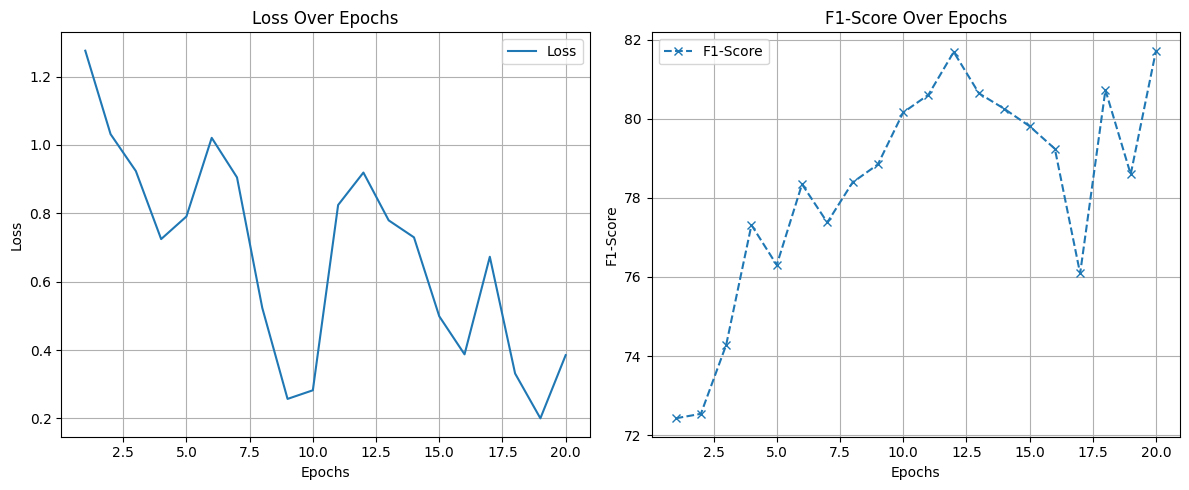

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plotting loss
epochs = [i for i in range(1,21)]
ax1.plot(epochs, loss_train, label='Loss')
ax1.set_title('Loss Over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plotting accuracy
ax2.plot(epochs, F1_Test, label='F1-Score', marker='x', linestyle='--')
ax2.set_title('F1-Score Over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('F1-Score')
ax2.legend()
ax2.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

###The confusion matrix

In [45]:
predictions = []
true_labels = []
with torch.no_grad():
  for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)
      predictions.extend(predicted.tolist())
      true_labels.extend(labels.tolist())

conf_matrix = confusion_matrix(true_labels, predictions)

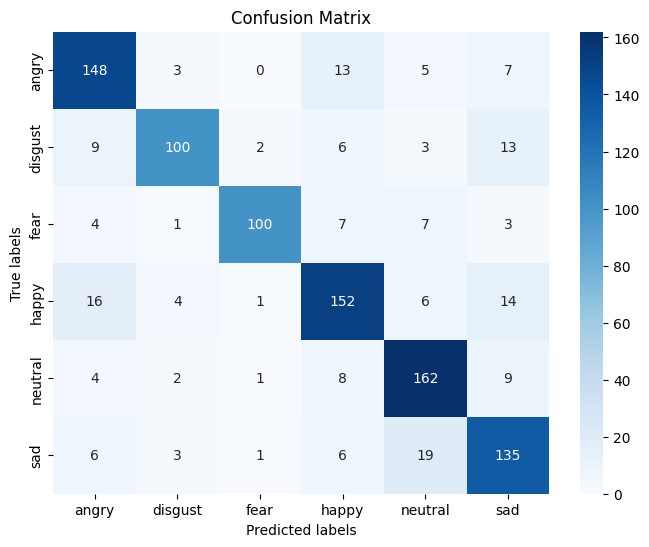

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(ticks=np.arange(len(dataset.classes)) + 0.5, labels=dataset.classes)
plt.yticks(ticks=np.arange(len(dataset.classes)) + 0.5, labels=dataset.classes)

plt.show()

###Saving the model

In [ ]:
model_save_name = 'SER_Teess_Savee_Ravdess_classifier.pth'
path = f"/content/drive/MyDrive/{model_save_name}"
torch.save(model.state_dict(), path)